In [47]:
import pandas as pd
df = pd.read_excel('/Users/ZHANGRY/Codes/Notebook_Files/Decision_Analytics/DABP-Project-Decarbonization/price/data.xlsx')
df['Price'] = df['Price'] / (10**3) # in kwh
df['Price'] = df['Price'] * 1.05 # EUR TO USD = 1.05, Dec 6
df.shape

(924, 2)

<AxesSubplot:xlabel='Time', ylabel='Price'>

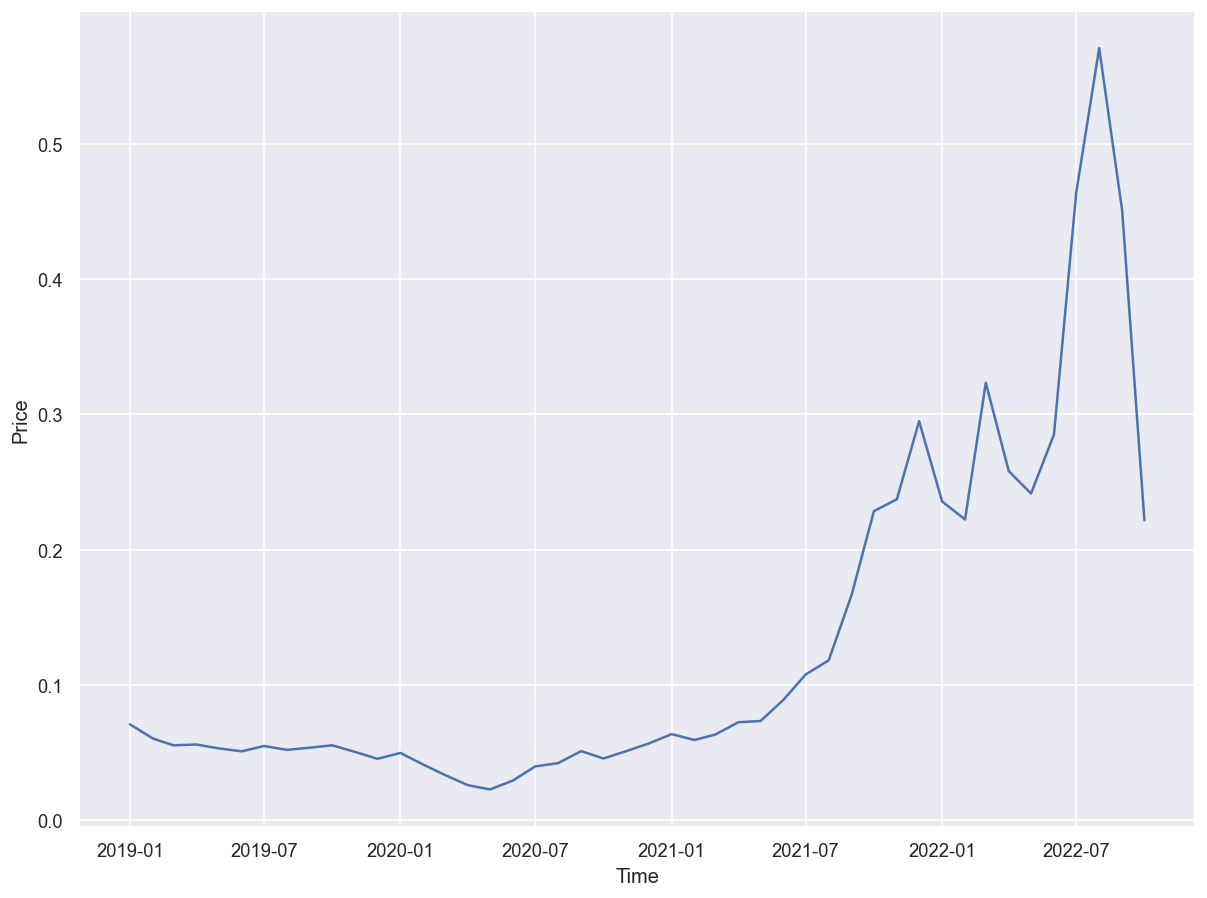

In [48]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 9)})
sns.set_theme(style="darkgrid")

# Plot the responses for different events and region
sns.lineplot(x="Time", y="Price", data=df)

In [49]:
# stationary test
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
series = df['Price'].dropna()
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.378543
p-value: 0.592518
Critical Values:
	1%: -3.627
	5%: -2.946
	10%: -2.612


Using Augmented Dickey-Fuller test, cannot Reject the null hypothesis (H0), the data has a unit root and is non-stationary.

Reference:
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

/opt/homebrew/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


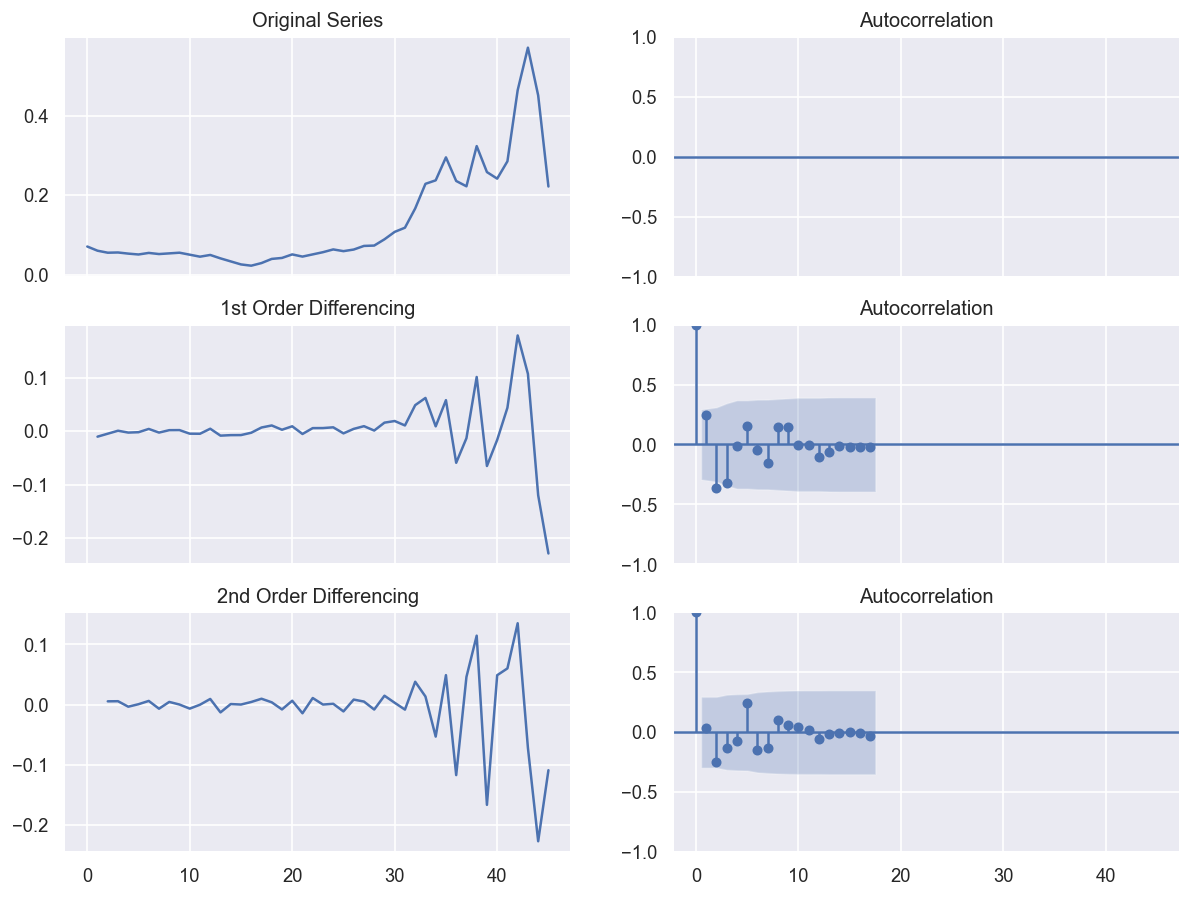

In [50]:
# deciding on the d
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(12,9), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df['Price']); axes[0, 0].set_title('Original Series')
plot_acf(df['Price'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df['Price'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['Price'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df['Price'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['Price'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [51]:
# adf test to validate
from pmdarima.arima.utils import ndiffs
ndiffs(df['Price'], test='adf')  # 2

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Look at the 1st order differencing. It's already stationary. Set d = 1. 

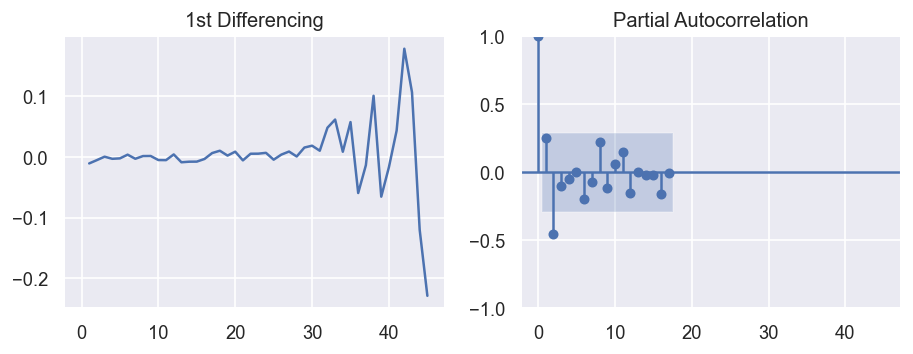

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df['Price'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df['Price'].diff().dropna(), ax=axes[1], method='ywm')

plt.show()

From partial autocorrelation: set p = 2

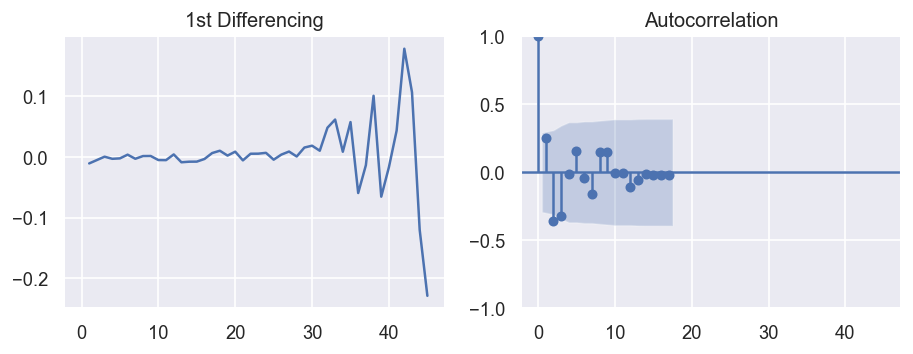

In [52]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df['Price'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df['Price'].diff().dropna(), ax=axes[1])

plt.show()

From autocorrelation: set q = 0

In [53]:
# set p = 0, d = 1, q = 0
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['Price'].dropna(), order = (2, 1, 0))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                   46
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  75.591
Date:                Tue, 06 Dec 2022   AIC                           -145.183
Time:                        12:49:27   BIC                           -139.763
Sample:                             0   HQIC                          -143.162
                                 - 46                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4723      0.091      5.203      0.000       0.294       0.650
ar.L2         -0.6550      0.110     -5.943      0.000      -0.871      -0.439
sigma2         0.0020      0.000      7.279      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):                15.74
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):             167.76   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [105]:
predict = fitted.predict(start = 46, end = 926, dynamic = False)
df_predict = pd.DataFrame(predict)
df_complete = pd.concat([df, df_predict], axis = 1)
df_complete.set_index("Time", inplace = True)
df_complete

,Price,predicted_mean
Time,,
2019-01-01,0.071032,NaN
2019-02-01,0.060522,NaN
2019-03-01,0.055471,NaN
2019-04-01,0.056070,NaN
2019-05-01,0.053204,NaN
...,...,...
2095-11-01,NaN,0.323624
2095-12-01,NaN,0.323624
NaT,NaN,0.323624


<AxesSubplot:xlabel='Time'>

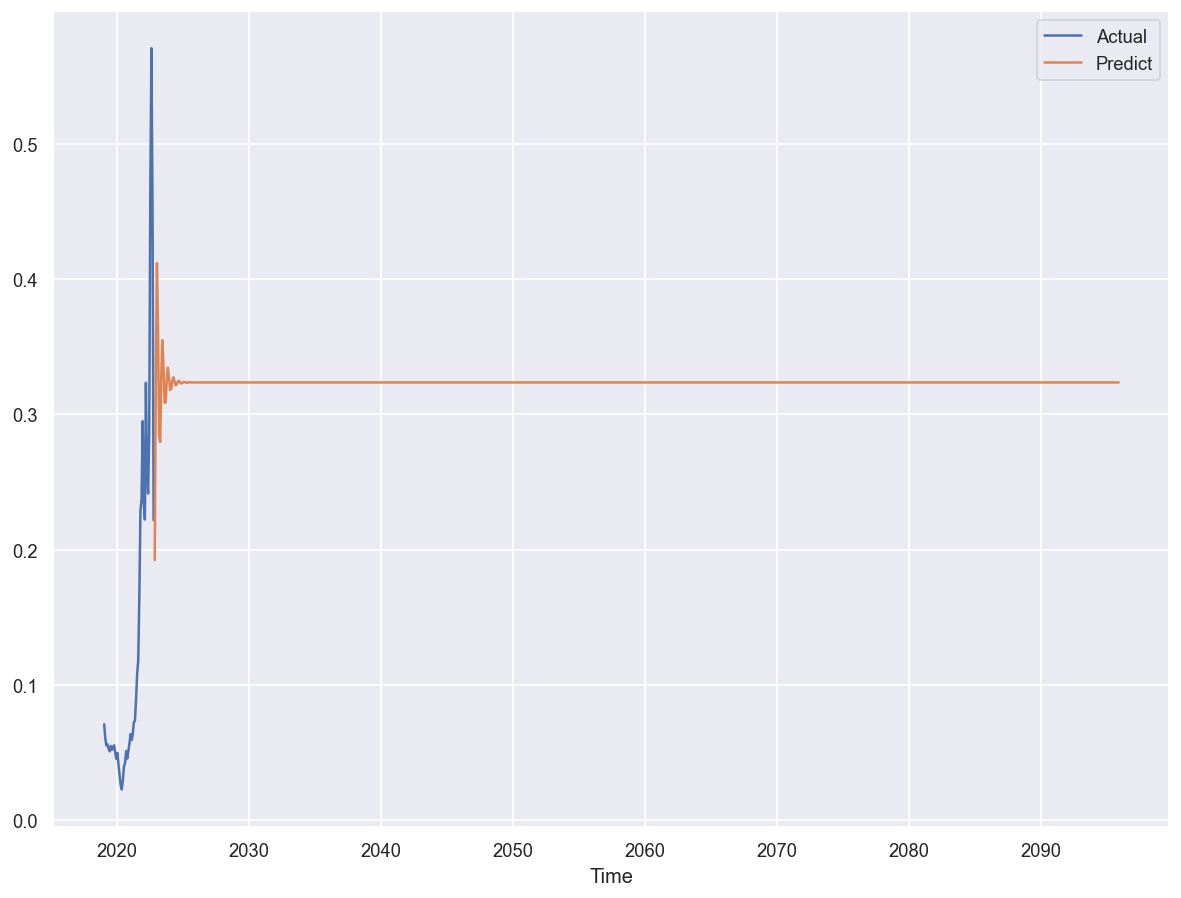

In [106]:
df_complete = df_complete.rename(columns = {'Price':'Actual', 'predicted_mean':'Predict'})
g = sns.lineplot(data = df_complete, 
    markers=False, dashes=False)
#g.set(ylim=(1*10**11, 4*10**11))
sns.set(rc={'figure.figsize':(12,9)})
g

In [117]:
df_actual = df_complete.drop(columns=['Predict']).iloc[24:46]
df_actual.columns = ['value']
df_predict = df_complete.drop(columns=['Actual']).iloc[46:]
df_predict.columns = ['value']
df_output = pd.concat([df_actual, df_predict], axis = 0)
df_output.head(20)

,value
Time,
2021-01-01,0.063735
2021-02-01,0.059399
2021-03-01,0.063431
2021-04-01,0.072523
2021-05-01,0.073437
2021-06-01,0.089124
2021-07-01,0.107856
2021-08-01,0.118293
2021-09-01,0.166688


In [118]:
df_output.index = df_output.index.year

In [120]:
df_out = df_output.groupby('Time')['value'].mean()
df_out.head(20)

Time
2021.0    0.131281
2022.0    0.316150
2023.0    0.330172
2024.0    0.323035
2025.0    0.323669
2026.0    0.323622
2027.0    0.323624
2028.0    0.323624
2029.0    0.323624
2030.0    0.323624
2031.0    0.323624
2032.0    0.323624
2033.0    0.323624
2034.0    0.323624
2035.0    0.323624
2036.0    0.323624
2037.0    0.323624
2038.0    0.323624
2039.0    0.323624
2040.0    0.323624
Name: value, dtype: float64

In [121]:
df_out.to_csv('price_arima.csv')

# Smoothing

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

oildata = df_data.copy()
fit1 = SimpleExpSmoothing(oildata, initialization_method="heuristic").fit(
    smoothing_level=0.2, optimized=False
)
fcast1 = fit1.forecast(3).rename(r"$\alpha=0.2$")
fit2 = SimpleExpSmoothing(oildata, initialization_method="heuristic").fit(
    smoothing_level=0.6, optimized=False
)
fcast2 = fit2.forecast(3).rename(r"$\alpha=0.6$")
fit3 = SimpleExpSmoothing(oildata, initialization_method="estimated").fit()
fcast3 = fit3.forecast(3).rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

plt.figure(figsize=(12, 8))
plt.plot(oildata, marker="o", color="black")
plt.plot(fit1.fittedvalues, marker="o", color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, marker="o", color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.plot(fit3.fittedvalues, marker="o", color="green")
(line3,) = plt.plot(fcast3, marker="o", color="green")
plt.legend([line1, line2, line3], [fcast1.name, fcast2.name, fcast3.name])

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

air = df_data.dropna().copy()
fit0 = SimpleExpSmoothing(air, initialization_method="estimated").fit()
fcast0 = fit0.forecast(75).rename("SES")
# fit1 = Holt(air, initialization_method="estimated").fit()
# fcast1 = fit1.forecast(75).rename("Holt's linear trend")
# # fit2 = Holt(air, exponential=True, initialization_method="estimated").fit()
# # fcast2 = fit2.forecast(75).rename("Exponential trend")
# fit3 = Holt(air, damped_trend=True, initialization_method="estimated").fit()
# fcast3 = fit3.forecast(75).rename("Additive damped trend")

plt.figure(figsize=(12, 8))
plt.plot(air, marker="o", color="black")
plt.plot(fit1.fittedvalues, color="red")
(line1,) = plt.plot(fcast0, marker="o", color="red")
# plt.plot(fit2.fittedvalues, color="red")
# (line2,) = plt.plot(fcast1, marker="o", color="red")
# plt.plot(fit3.fittedvalues, color="green")
# (line3,) = plt.plot(fcast3, marker="o", color="green")
# plt.legend([line1, line2, line3], [fcast0.name, fcast1.name, fcast3.name])
plt.legend([line1], [fcast0.name])




In [ ]:
fcast0.to_csv("demand_prediction_ses.csv")

References:
https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

https://www.statista.com/statistics/799638/total-electricity-consumption-in-italy/

https://www.statsmodels.org/v0.12.0/generated/statsmodels.tsa.arima_model.ARIMA.predict.html


